In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 150)

# Trivial Projector
What happens if we just take a player's cumulative mean fantasy points as the projection?

In [2]:
from dfsmc.simulate import projection

projection_results = projection.get_projections(range(2017,2023), projection.TrivialProjector)
print(projection_results.columns)
print(projection_results.sort_values(by='res_sq', ascending=True).head(100))

Warning! Trivial Projector was not initialized with a week number so it is projecting for all available weeks
Warning! Trivial Projector was not initialized with a week number so it is projecting for all available weeks
Warning! Trivial Projector was not initialized with a week number so it is projecting for all available weeks
Warning! Trivial Projector was not initialized with a week number so it is projecting for all available weeks
Warning! Trivial Projector was not initialized with a week number so it is projecting for all available weeks
Warning! Trivial Projector was not initialized with a week number so it is projecting for all available weeks
Index(['name_display', 'draftkings_points_predicted', 'team_name_abbr', 'pos_game', 'week_num', 'year', 'draftkings_points', 'rush_att', 'pass_att',
       'targets', 'res', 'res_sq'],
      dtype='object')
              name_display  draftkings_points_predicted team_name_abbr pos_game  week_num  year  draftkings_points  rush_att  pass_at

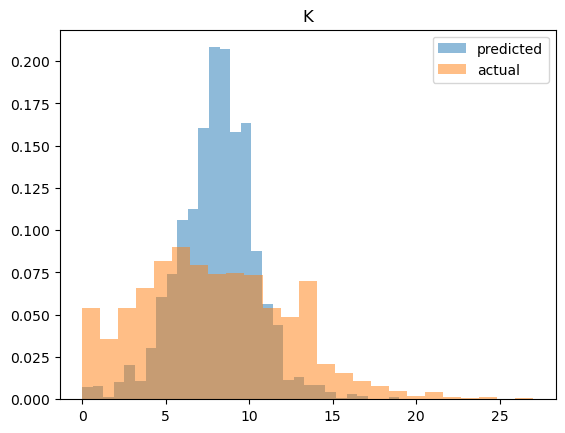

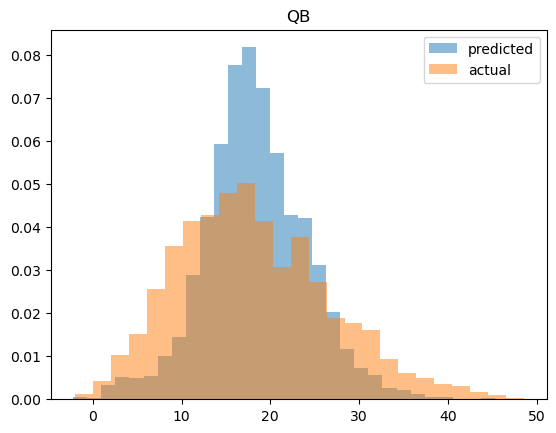

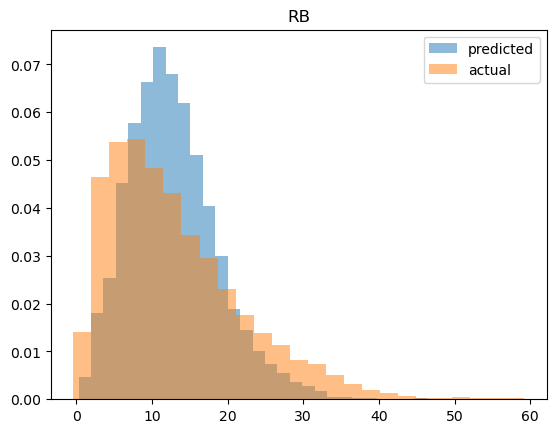

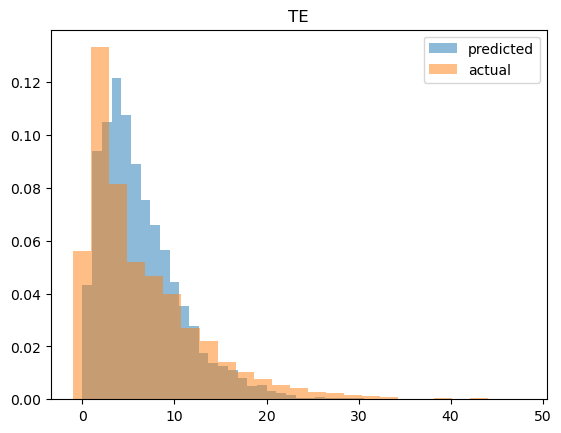

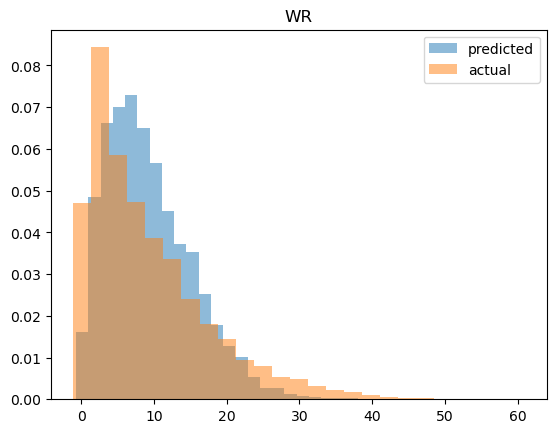

In [3]:
positions = projection_results.groupby('pos_game')

# print(projection_results.loc[positions.groups['QB']])

for pos, df in positions:
    plt.figure()
    plt.hist(df['draftkings_points_predicted'], density=True, bins=30, alpha=0.5, label='predicted')
    plt.hist(df['draftkings_points'], density=True, bins=25, alpha=0.5, label='actual')
    plt.title(pos)
    plt.legend()

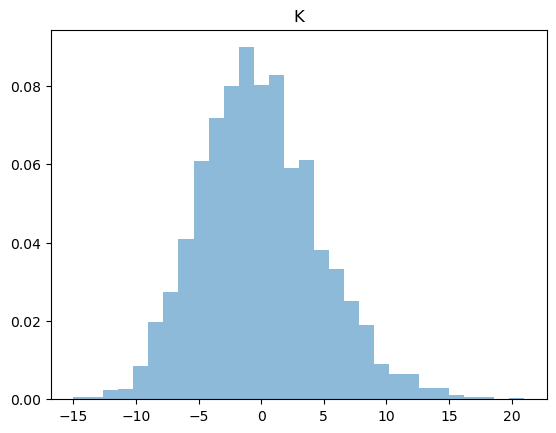

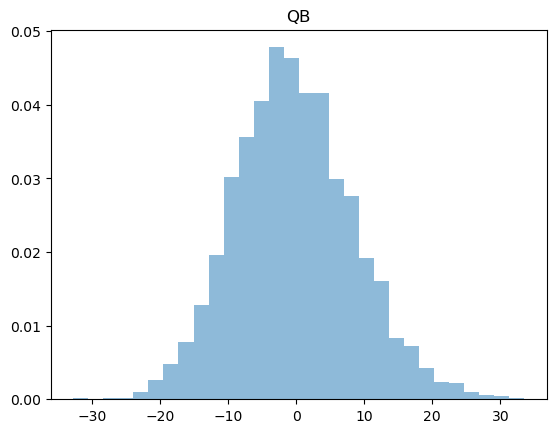

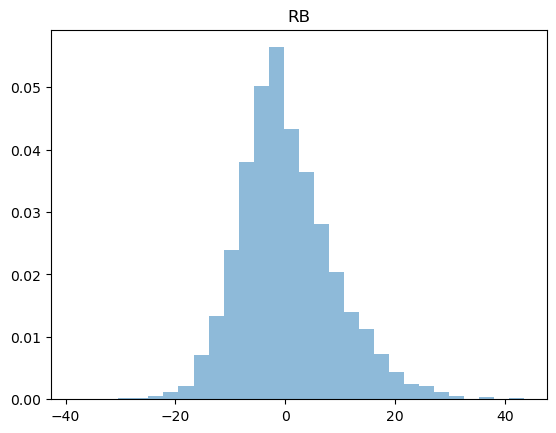

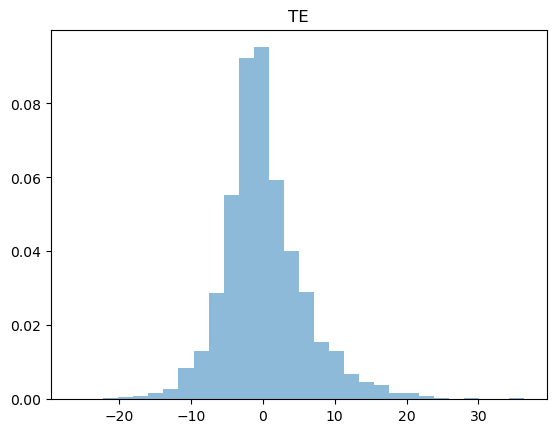

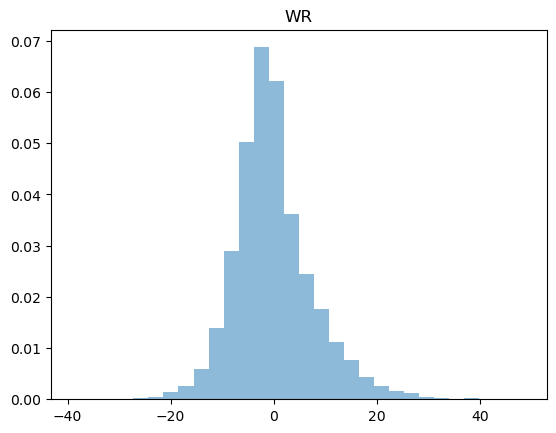

In [4]:
for pos, df in positions:
    plt.figure()
    plt.hist(df['draftkings_points'] - df['draftkings_points_predicted'], density=True, bins=30, alpha=0.5)
    plt.title(pos)

In [5]:
print(positions.get_group('K').sort_values(by='draftkings_points_predicted', ascending=False).head(10))
print(positions.get_group('K').sort_values(by='draftkings_points', ascending=False).head(10))

            name_display  draftkings_points_predicted team_name_abbr pos_game  week_num  year  draftkings_points  rush_att  pass_att  targets  \
24637       Younghoe Koo                        19.00            ATL        K         2  2022                5.0       0.0       0.0      0.0   
22288  Giorgio Tavecchio                        19.00            OAK        K         2  2017                9.0       0.0       0.0      0.0   
20222      Greg Zuerlein                        17.00            LAR        K         2  2017                9.0       0.0       0.0      0.0   
24244    Harrison Butker                        17.00            KAN        K         2  2019                4.0       0.0       0.0      0.0   
12697      Greg Zuerlein                        17.00            LAR        K         7  2018               13.0       0.0       0.0      0.0   
20830    Harrison Butker                        16.50            KAN        K         6  2017                8.0       0.0       0